In [14]:
import pandas as pd
import numpy as np
import ConfigParser, os
import seaborn as sea
import matplotlib.pyplot as plt

sea.set(font_scale=2)  # crazy big

%matplotlib inline

def df_mensajes_log_a_df(patron, nombrearchivo):
    mensajes = !grep '$patron' $nombrearchivo
    qss_mensajes = pd.DataFrame([val.split(' / ') for val in mensajes])
    return qss_mensajes

def obtener_patrones(nombrearchivo):
    patrones = ! awk ' { print $1 " " $2 " " $3 " " $4 " " $5 } ' $nombrearchivo  | sort -u
    return patrones

def nombres_modelos(logfile_name):    
    logdir_name = os.path.dirname(logfile_name)
    config = ConfigParser.ConfigParser()
    config.readfp(open(logfile_name))
    
    fn_parallelroot = config.get('logfiles', 'parallelroot')
    fn_top = config.get('logfiles', 'top')

    atomics = { mod_name: os.path.join(logdir_name, fn_mod) for (mod_name, fn_mod) 
               in config.items('logfiles')}
               #if mod_name not in ("top", "parallelroot")}
    return atomics

from matplotlib.colors import LogNorm
dataframes = []

logs = []
info_atomicos = nombres_modelos("teacuplogs/head_log")


modelos = {}
patrones = ['0 / L / X', 
            '0 / L / @',
            '0 / L / \*',
            '0 / L / D',
            '0 / L / I',
            '0 / L / Y']

for nombre_atomico, archivo_log in info_atomicos.items():
    for patron in patrones:
        modelos[nombre_atomico] = modelos.get(nombre_atomico, {patron: None})
        modelos[nombre_atomico][patron] = df_mensajes_log_a_df(patron, archivo_log)
        

for k, v in modelos.items():
    for kk, vv in v.items():
        dataframes.append(pd.DataFrame({'modelo': k, 'mensaje': kk[-1], 'cantidad': len(vv)}, index=[0]))

/home/danito/ambientes/py2_notebooks/lib/python2.7/site-packages/ipykernel_launcher.py:35: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated


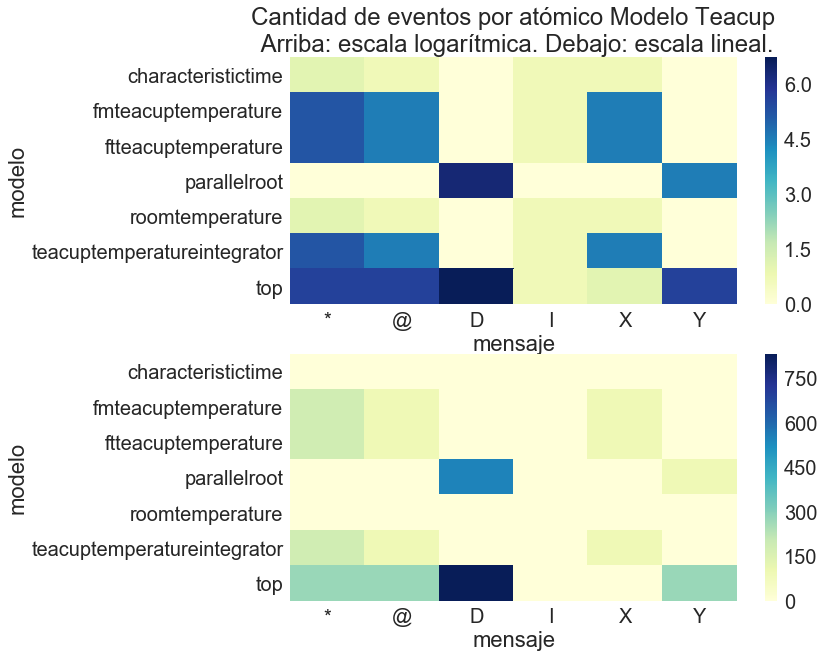

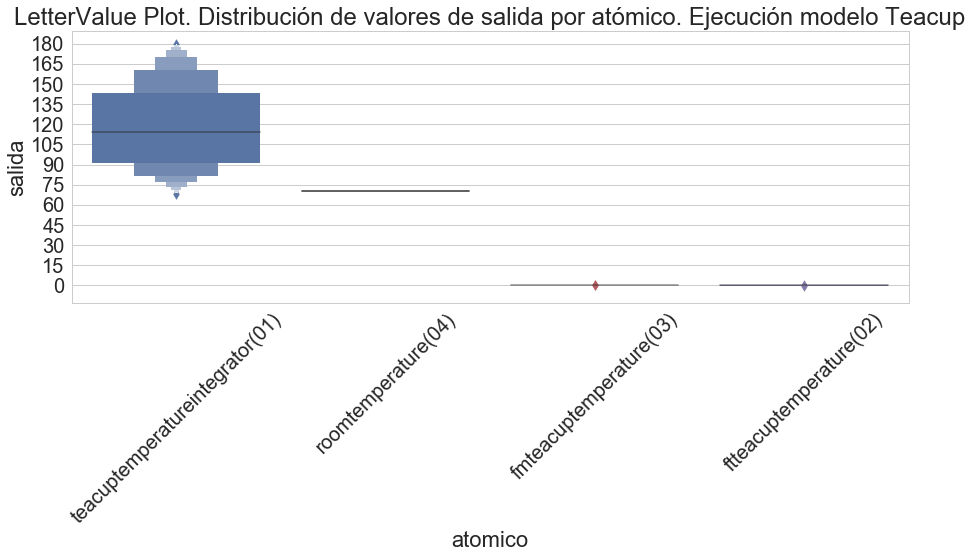

In [18]:
sumarizado_mensajes = pd.concat(dataframes)
sumarizado_mensajes['log_cantidad'] = np.log(sumarizado_mensajes.cantidad + 1)

sum_msgs_log = sumarizado_mensajes.pivot('modelo', 'mensaje', 'log_cantidad')
sum_msgs = sumarizado_mensajes.pivot('modelo', 'mensaje', 'cantidad')

f, (ax1, ax2) = plt.subplots(2, 1, sharey=True, figsize=(10,10))
sea.heatmap(sum_msgs_log, cmap="YlGnBu", ax=ax1)
sea.heatmap(sum_msgs, cmap="YlGnBu",ax=ax2)
ax1.set_title(u'Cantidad de eventos por atómico Modelo Teacup\n Arriba: escala logarítmica. Debajo: escala lineal.')
plt.savefig('tea_cantidad_mensajes.png')

salidas = modelos['top']['0 / L / Y'].copy()

aux = salidas[6].str.replace(']', '')
aux2 = aux.str.replace('[', '')
salidas['valor_out'] = pd.to_numeric(aux2)

salidas_int = salidas[salidas[4] == 'int(01)']
salidas_int['x'] = range(0, np.shape(salidas_int)[0])

del salidas[3]
del salidas[5]

del salidas[6]
del salidas[7]

salidas.columns = ['id','tipo','evento', 'atomico', 'valor_out']


sea.set_style("whitegrid")

salidas['salida'] = pd.to_numeric(salidas['valor_out'])
fig, ax = plt.subplots(figsize=(15,5))
g= sea.lvplot(data=salidas.ix[ salidas['atomico'] != 'characteristictime(05)', ], x='atomico', y='salida', ax=ax)
ax.set_title(u'LetterValue Plot. Distribución de valores de salida por atómico. Ejecución modelo Teacup')
#g.set_xticklabels(rotation=30)

plt.xticks(rotation=45)
import matplotlib.ticker as plticker

loc = plticker.MultipleLocator(base=15.0) # this locator puts ticks at regular intervals
ax.yaxis.set_major_locator(loc)

plt.savefig('tea_output_letter_plot.png')

[[]]

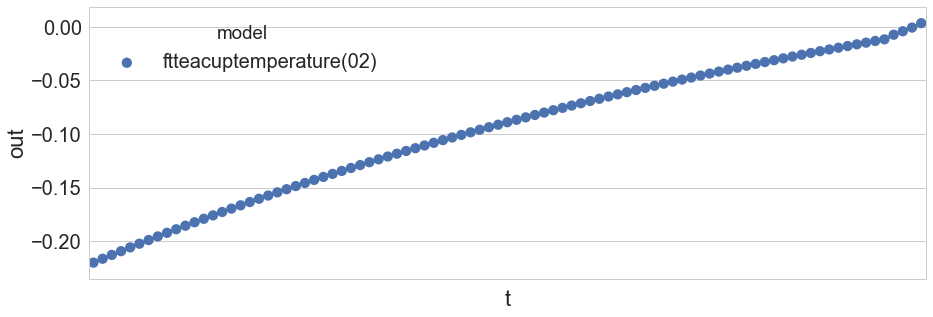

In [19]:
salidas = modelos['top']['0 / L / Y']
outputs = salidas.iloc[:,[3,4,6]].copy()
outputs["out"] = pd.to_numeric(outputs[6].str.replace("[", "").str.replace("]", ""))

def string_t_cd_a_int(val):
    acum = 0
    vals = [float(x) for x in val.strip().split(':')]
    acum = vals[0]*3600 + vals[1] * 60 + vals[2] + vals[3]/1000
    return acum

outputs['t'] = outputs[3].apply(string_t_cd_a_int)

outputs['model'] = outputs[4]


plt.figure(figsize=(15,5))
g = sea.pointplot(x='t', y='out', hue='model', data=outputs[outputs.model == 'ftteacuptemperature(02)'])
g.set(xticklabels=[])




